In [1]:
%matplotlib inline

$\newcommand{\x}{\mathbf{x}}$
$\newcommand{\a}{\mathbf{a}}$

# The problem
We have a set of $n$ numbers $\a$, and we want to flip their signs such that the numbers sum to zero, with the minimum possible number of flips. 

In [130]:
# This list of 120 numbers was generated with a known solution using 60 flips
# However, a smaller number should be possible
a = [25, 15, 14, 18, 30, 16, 27, 16, 14, 39, 15, 20, 35, 24, 3, 19, 21, 35, 24, 30, 19, 6, 40, 35, 28, 1, 19, 22, 9,
     46, 7, 6, 10, 7, 10, 1, 11, 10, 30, 16, 3, 20, 34, 5, 17, 22, 39, 6, 20, 9, 8, 17, 23, 1, 16, 9, 9, 26, 8, 22, 
     26, 13, 11, 13, 7, 7, 18, 8, 28, 18, 18, 24, 8, 15, 31, 28, 14, 19, 15, 23, 1, 7, 37, 8, 14, 35, 33, 30, 7, 3, 1,
     17, 14, 12, 36, 21, 5, 13, 2, 36, 2, 4, 30, 30, 8, 19, 18, 2, 8, 7, 4, 6, 3, 24, 24, 19, 9, 40, 14, 28, 7, 10, 7]

## Greedy algorithm

Pick the biggest number that can be flipped without making the sum go below 0, and flip it. Repeat until the solution is found.

I'm 98% confident that this will always find a solution, and 95% confident that it will be optimal.

In [134]:
# Sort the array from largest to smallest
b = np.sort(a*10)[::-1]
flips = np.ones(len(b))
current = sum(b)
i = 0

# Quit the loop when we're successful, or we get to the end
while current!=0 and i < len(b):
    # Flip the next largest number, if it's not too big
    if current - b[i]*2 >= 0:
        flips[i] = flips[i] * -1
        current -= b[i]*2
    i+=1
print "Solution:", b * flips
print "Number of flips:", len(flips[flips < 0])
print "Solution sums to: ", sum(b*flips)

Solution: [-46. -46. -46. ...,   1.   1.   1.]
Number of flips: 330
Solution sums to:  0.0



## Linear programming

This may also be reformulated as an [integer linear programming (ILP)](http://en.wikipedia.org/wiki/Integer_programming)  problem.

The vector $\x$ is a list of binary coefficients, where each $x_i \in \{0, 1\}$. The problem is:

$$\begin{align} 
\textrm{mininimse} & \sum_{i=1}^n x_i \\
\textrm{subject to} & \sum_{i=1}^n (2x_i-1)a_i = 0
\end{align}$$

The constraint may be rearranged:
$$
\textrm{subject to}  \sum_{i=1}^n 2x_ia_i = \sum_{i=1}^n a_i
$$

Hence, the final problem expressed using vectors:
$$\begin{align} 
\textrm{mininimse} \quad & ||\x|| \\
\textrm{subject to} \quad & \x^T(2\a) = ||\a||
\end{align}$$

Thankfully, ILP solvers exist, so we don't actually have to come up with a decent algorithm for computing this directly. I chose PuLP because it was easy to install without third party dependancies and looked fairly simple to use with Python. See: https://pypi.python.org/pypi/PuLP/1.1



In [132]:
from pulp import LpProblem, LpVariable, lpSum, LpMinimize, LpAffineExpression, value, solvers
import numpy as np

def solve_problem(a):
    problem = LpProblem('prob', LpMinimize)

    # Define the set of coefficients (flips)
    x = [LpVariable('x_'+str(i), 0, 1, cat='Binary') for i in range(len(a))]

    # Set sum(x) to be the thing to minimise
    minimiser = lpSum(LpAffineExpression((var, 1) for var in x))
    problem += minimiser

    # Add sum(2*x*a)==sum(a), the problem constraint
    constraint = lpSum(LpAffineExpression((var, val*2) for var, val in zip(x, a))) == np.sum(a)
    problem += constraint 

    # Solve!
    if solvers.PULP_CBC_CMD().solve(problem):
        return problem, x
    else:
        raise Exception("Failed to find solution")
        
# This list of 120 numbers was generated with a known solution using 60 flips
# However, a smaller number should be possible

problem, x = solve_problem(a)

In [133]:
print "Number of flips: {} (max {})".format(value(problem.objective), len(a)/2)
solution = np.array([-(v.varValue*2-1) * n for v, n in zip(x, a)])
print np.sort(solution)
print "Solution sums to:", np.sum(solution)



Number of flips: 33.0 (max 61)
[-46. -40. -40. -39. -39. -37. -36. -36. -35. -35. -35. -35. -34. -33. -31.
 -30. -30. -30. -30. -30. -30. -28. -28. -28. -28. -27. -26. -26. -25. -24.
 -24. -24. -24.   1.   1.   1.   1.   1.   2.   2.   2.   3.   3.   3.   3.
   4.   4.   5.   5.   6.   6.   6.   6.   7.   7.   7.   7.   7.   7.   7.
   7.   7.   8.   8.   8.   8.   8.   8.   8.   9.   9.   9.   9.   9.  10.
  10.  10.  10.  11.  11.  12.  13.  13.  13.  14.  14.  14.  14.  14.  14.
  15.  15.  15.  15.  16.  16.  16.  16.  17.  17.  17.  18.  18.  18.  18.
  18.  19.  19.  19.  19.  19.  19.  20.  20.  20.  21.  21.  22.  22.  22.
  23.  23.  24.]
Solution sums to: 0.0


### Crude benchmarking...
Can we explore the speed of this solver as $\a$ grows?

Because I'm lazy, we'll just try by repeating the $\a$ array many times, so this is probably not very representative of reality.

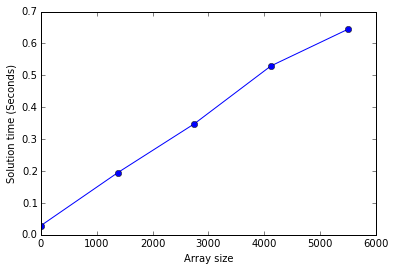

In [129]:
import matplotlib.pyplot as plt

times = []
sizes = []
for i in range(5):
    # Repeat the array i^2 times
    g = a * (i*3)
    # Solve the problem, record the time
    problem, x = solve_problem(g)
    sizes.append(len(g))
    times.append(problem.solutionTime)

plt.plot(sizes, times, 'o-')
plt.xlabel('Array size')
plt.ylabel('Solution time (Seconds)')